In [1]:
import keras
import wget as wg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline
from decimal import Decimal
import warnings
warnings.filterwarnings("ignore")
import pickle
from keras.models import model_from_json

Using TensorFlow backend.


In [9]:
X=pd.read_csv('~/Desktop/ML/ten_skus.csv')
X=X.iloc[0:,:]
list(X.columns.values)

['id',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'SchoolHoliday',
 'High_Var',
 'Luxury']

In [3]:
X.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,High_Var,Luxury
0,1.0,2.0,1/1/13,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,3.0,1/2/13,5530.0,668.0,1.0,0.0,1.0,0.0,1.0
2,1.0,4.0,1/3/13,4327.0,578.0,1.0,0.0,1.0,0.0,1.0
3,1.0,5.0,1/4/13,4486.0,619.0,1.0,0.0,1.0,0.0,1.0
4,1.0,6.0,1/5/13,4997.0,635.0,1.0,0.0,1.0,0.0,1.0


In [10]:
sequence_length=7

def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0] #number of rows
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop,:]

In [26]:
sequence_cols = ['id','DayOfWeek','Sales','Customers','Open','Promo','SchoolHoliday','High_Var','Luxury']
# generator for the sequences
seq_gen = (list(gen_sequence(X[X['id']==id], sequence_length, sequence_cols)) 
           for id in X['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array[934]

array([[  1.00000000e+00,   5.00000000e+00,   3.70600000e+03,
          4.59000000e+02,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   6.00000000e+00,   4.36400000e+03,
          5.00000000e+02,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   6.10200000e+03,
          6.12000000e+02,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   2.00000000e+00,   5.01100000e+03,
          5.60000000e+02,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   3.00000000e+00,   4.78200000e+03,
   

In [15]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [27]:
# generate labels
label_gen = [gen_labels(X[X['id']==id], sequence_length, ['Sales']) 
             for id in X['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array[934]

array([ 5263.], dtype=float32)

In [195]:
seq_array[0]


array([[  2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+01,   1.00000000e+00],
       [  3.00000000e+00,   6.04360000e+04,   1.00000000e+01,
          0.00000000e+00,   1.00000000e+01,   2.00000000e+00],
       [  4.00000000e+00,   5.28480000e+04,   1.00000000e+01,
          0.00000000e+00,   8.00000000e+00,   3.00000000e+00]], dtype=float32)

In [18]:
len(seq_array)

9350

In [28]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

#model.add(LSTM(input_shape=(sequence_length, nb_features),units=21,return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(input_shape=(sequence_length, nb_features),units=21,return_sequences=False))
#model.add(Dense(units=2))

model.add(Dense(units=1,activation='linear'))
model.compile(loss="mse", optimizer="sgd", metrics=['mae','mse'])

model.fit(seq_array, label_array, epochs=200, batch_size=20, verbose=0)
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=1)

print('Mean Abs Error: {}'.format(scores[1],0)  )
print('MSE: {}'.format(scores[2]/10000000,0)  )


prediction=model.predict(seq_array, verbose=1)

9350/9350 [==============================] - 19s 2ms/step
Mean Abs Error: 2422.1649655853107
MSE: 0.9841171621875722
9350/9350 [==============================] - 1s 66us/step


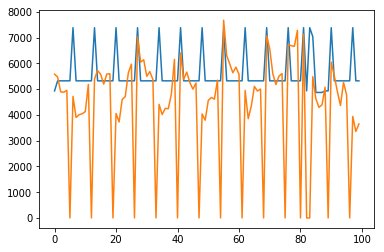

In [33]:
y1=X.iloc[sequence_length:,].reset_index(drop=True)
y1=y1.loc[:,'Sales']
#y1.shape

pred2 = pd.DataFrame(prediction)
pred3=pd.concat([pred2,y1],axis=1)
#pred3.head()

plt.plot(pred3.iloc[:100,0]   ) 
plt.plot(pred3.iloc[:100,1]   ) 

#plt.show()

In [32]:
pred3.iloc[:10,:]

,0,Sales
0,4931.867188,5580
1,5322.408691,5471
2,5322.408691,4892
3,5322.408691,4881
4,5322.408691,4952
5,5322.408691,0
6,7385.768555,4717
7,5322.408691,3900
8,5322.408691,4008
9,5322.408691,4044


In [187]:
#pred2.to_csv('~/Desktop/ML/predictions.csv')

In [63]:
# BUILD REGULAR NON-LSTM, RNN MODEL

X=pd.read_csv('~/Desktop/ML/ten_skus.csv')
X=X.iloc[0:40,:]


y=X['Sales']
Xs=X[['id','DayOfWeek','Open','Promo','SchoolHoliday']]
Xs['lagSales'] = X['Sales'].shift(1)
Xs['lagCust'] = X['Customers'].shift(1)
#Xs['Mov_avg']=pd.rolling_mean(X['Sales'], window=7).shift(1)

y=y[2:]

y.reset_index(drop=True, inplace=True)
Xs=Xs.iloc[2:,:]
Xs.reset_index(drop=True, inplace=True)
Xs.head()

,id,DayOfWeek,Open,Promo,SchoolHoliday,lagSales,lagCust
0,1,4,1,0,1,5530.0,668.0
1,1,5,1,0,1,4327.0,578.0
2,1,6,1,0,1,4486.0,619.0
3,1,7,0,0,1,4997.0,635.0
4,1,1,1,1,1,0.0,0.0


In [64]:
y.head()

0    4327
1    4486
2    4997
3       0
4    7176
Name: Sales, dtype: int64

In [68]:
model = Sequential()
model.add(Dense(20, input_dim=Xs.shape[1], activation='linear'))
model.add(Dense(50, activation='linear'))
model.add(Dense(30, activation='linear'))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
# Fit the model
model.fit(Xs, y, epochs=1000, batch_size=2, verbose=0)
# evaluate the model
scores = model.evaluate(Xs, y)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print("%s: %.0f"%  (model.metrics_names[1], scores[1]))
print("%s: %.1f"%  (model.metrics_names[2], scores[2]/10000000))

prediction2=model.predict(Xs, verbose=0)

38/38 [==============================] - 0s 3ms/step
mean_absolute_error: 809
mean_squared_error: 0.1


In [73]:
print('MAE: 809')
print('MSE: 0.1')

MAE: 809
MSE: 0.1


In [70]:
# serialize model to JSON
model_json = model.to_json()
with open("NCSU_DC.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NCSU_DC.h5")
print("Saved model to disk")

Saved model to disk


In [71]:
# load json and create model
json_file = open('NCSU_DC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("NCSU_DC.h5")
print("Loaded model from disk")

Loaded model from disk


In [72]:
# evaluate loaded model on test data
loaded_model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
score = loaded_model.evaluate(Xs, y, verbose=0)
print("%s: %.0f"%  (loaded_model.metrics_names[1], score[1]))
print("%s: %.1f"%  (loaded_model.metrics_names[2], score[2]/10000000))

mean_absolute_error: 809
mean_squared_error: 0.1


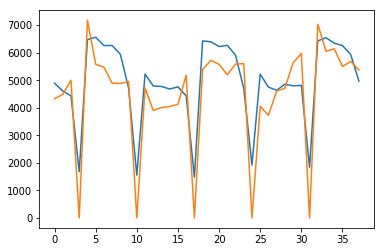

In [69]:
pred2=pd.DataFrame(prediction2)
pred3=pd.concat([pred2,y],axis=1)
#pred3.head()

plt.plot(pred3.iloc[:50,0]   ) 
plt.plot(pred3.iloc[:50,1]   )

#plt.show()

In [427]:
pred3.iloc[:12,]

,0,Sales
0,62498.851562,60436
1,57663.335938,52848
2,57345.535156,55606
3,41966.773438,43727
4,1743.363525,0
5,70284.820312,89391
6,69647.234375,72552
7,69359.898438,64297
8,69044.242188,64112
9,68702.062500,65006
